## Importing

In [55]:
import pandas as pd
import csv

df = pd.read_csv('training_data_w_ingredients.csv', sep=';', error_bad_lines=False)
df.iloc[0]

Unnamed: 0                                                     1
index                                                          1
name                                         Vietnamese Pho Soup
ingredients    ['8 cups beef broth', '4 cups water', '1 yello...
cuisine                                               Vietnamese
Name: 0, dtype: object

In [56]:
print("Document Count")
print(df.groupby('cuisine')['ingredients'].count())

Document Count
cuisine
Chinese       60
Greek         50
Iberic        40
Italian       50
Thai          50
Vietnamese    50
french        50
korean        50
Name: ingredients, dtype: int64


# Data Exploration

## General look up
The goal is to get a first impression of the most common words.

In [57]:
from collections import Counter
df['ingredients'] = df['ingredients']
Counter(" ".join(df["ingredients"]).split()).most_common(5)

[("'1", 1635),
 ("'2", 789),
 ('cup', 729),
 ('teaspoon', 685),
 ('tablespoons', 605)]

None of these words are relevant for our further analysis of the Data.

Let's have a look at the typical count of ingredients.

In [4]:
df['ingredients'].str.split().str.len().head()

0    100
1     57
2     59
3     44
4     70
Name: ingredients, dtype: int64

## Let's make it more intresting
With scattertextplot we can visualize the words and the frequenz of them

In [5]:
##import
import string
%matplotlib inline
import scattertext as st
import re, io
from pprint import pprint
import pandas as pd
import numpy as np
from scipy.stats import rankdata, hmean, norm
import spacy
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer

In [6]:
# error handling https://stackoverflow.com/questions/66149878/e053-could-not-read-config-cfg-resumeparser
nlp = spacy.load('en_core_web_sm')

In [7]:
df.head()

,Unnamed: 0,index,name,ingredients,cuisine
0,1,1,Vietnamese Pho Soup,"['8 cups beef broth', '4 cups water', '1 yello...",Vietnamese
1,2,2,Vietnamese Chicken Meatballs,"['1 pound ground chicken', '3 tablespoons fish...",Vietnamese
2,3,3,Vietnamese Restaurant-Style Grilled Lemongrass...,"['1 pound pork blade steaks (boneless, about 1...",Vietnamese
3,4,4,Vietnamese Caramel Chicken,"['1 pound chicken thighs (with skin, deboned)'...",Vietnamese
4,5,5,Cheater Vietnamese Pho (Pho Bo),"['3 marrow bones (beef bone)', '50 ounces beef...",Vietnamese


## Words to Remove 
This code and these word lists are copied over as is.

In [8]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

#Source for list below
#https://en.wikipedia.org/wiki/Cooking_weights_and_measures
#https://thebakingpan.com/ingredient-weights-and-measures/
measures=['ounces','tablespoons','litrbes','liter','millilitres','mL','grams','g', 'kg','teaspoon','tsp', 'tablespoon','tbsp','fluid', 'ounce','oz','fl.oz', 'cup','pint','pt','quart','qt','gallon','gal','smidgen','drop','pinch','dash','scruple','dessertspoon','teacup','cup','cups','c','pottle','gill','dram','wineglass','coffeespoon','pound','pounded','lb','tbsp','plus','firmly', 'packed','lightly','level','even','rounded','heaping','heaped','sifted','bushel','peck','stick','chopped','sliced','halves', 'shredded','slivered','sliced','whole','paste','whole',' fresh', 'peeled', 'diced','mashed','dried','frozen','fresh','peeled','candied','no', 'pulp','crystallized','canned','crushed','minced','julienned','clove','head', 'small','large','medium', 'torn', 'cleaned', 'degree']

#measures = [lemmatizer.lemmatize(m) for m in measures]
#some of these include data leakage words, like 'italian' - ok to remove after including bigrams
data_leaks = ['iberic','greek', 'korean','italianstyle', 'french','thai', 'chinese', 'mexican','spanish','indian','italian']

common_remove=['ground','to','taste', 'and', 'or',  'can',  'into', 'cut', 'grated', 'leaf','package','finely','divided','a','piece','optional','inch','needed','more','drained','for','flake','dry','thinly','cubed','bunch','cube','slice','pod','beaten','seeded','uncooked','root','plain','heavy','halved','crumbled','sweet','with','hot','room','temperature','trimmed','allpurpose','deveined','bulk','seasoning','jar','food','if','bag','mix','in','each','roll','instant','double','such','frying','thawed','whipping','stock','rinsed','mild','sprig','freshly','toasted','link','boiling','cooked','unsalted','container',
'cooking','thin','lengthwise','warm','softened','thick','quartered','juiced','pitted','chunk','melted','cold','coloring','puree','cored','stewed','floret','coarsely','the','blanched','zested','sweetened','powdered','garnish','dressing','soup','at','active','lean','chip','sour','long','ripe','skinned','fillet','from','stem','flaked','removed','stalk','unsweetened','cover','crust', 'extra', 'prepared', 'blend', 'of', 'ring',  'undrained', 'about', 'zest', ' ', '', 'spray', 'round', 'herb', 'seasoned', 'wedge', 'bitesize', 'broken', 'square', 'freshly', 'thickly', 'diagonally']
#common_remove = [lemmatizer.lemmatize(c) for c in common_remove]
#data_leaks = [lemmatizer.lemmatize(d) for d in data_leaks]
# due to using bigrams not including 
useless_singles=['','black','white','red','yellow','seed','breast','confectioner','sundried','broth','bell','baby','juice','crumb','sauce','condensed','smoked','basmati','extravirgin','brown','clarified', 'soy', 'filling', 'pine', 'virgin', 'romano', 'heart', 'shell', 'thigh', 'boneless','skinless','split', 'dark', 'wheat', 'light', 'green', 'vegetable', 'curry', 'orange', 'garam', 'sesame', 'strip', 'sea', 'canola', 'mustard','powder', 'ice', 'bay', 'roasted', 'loaf', 'roast', 'powder']
useless_singles = [lemmatizer.lemmatize(u) for u in useless_singles]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adrianawad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Clean up

In [9]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    filtered_words = [w for w in filtered_words if not w in measures]
    filtered_words = [w for w in filtered_words if not w in data_leaks]
    filtered_words = [w for w in filtered_words if not w in common_remove]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]

    return " ".join(filtered_words)


# Apply to the DF series
df['cleanText']=df['ingredients'].map(lambda s:preprocess(s)) 
df['cleanTextList']=df['ingredients'].map(lambda s:preprocess(s).split()) 
df['parsed'] = df.cleanText.apply(nlp)
df.sample(10)
df.head(5)

,Unnamed: 0,index,name,ingredients,cuisine,cleanText,cleanTextList,parsed
0,1,1,Vietnamese Pho Soup,"['8 cups beef broth', '4 cups water', '1 yello...",Vietnamese,beef broth water yellow onion cloves garlic ro...,"[beef, broth, water, yellow, onion, cloves, ga...","(beef, broth, water, yellow, onion, cloves, ga..."
1,2,2,Vietnamese Chicken Meatballs,"['1 pound ground chicken', '3 tablespoons fish...",Vietnamese,chicken fish sauce onion cloves garlic lemongr...,"[chicken, fish, sauce, onion, cloves, garlic, ...","(chicken, fish, sauce, onion, cloves, garlic, ..."
2,3,3,Vietnamese Restaurant-Style Grilled Lemongrass...,"['1 pound pork blade steaks (boneless, about 1...",Vietnamese,pork blade steaks boneless light brown sugar g...,"[pork, blade, steaks, boneless, light, brown, ...","(pork, blade, steaks, boneless, light, brown, ..."
3,4,4,Vietnamese Caramel Chicken,"['1 pound chicken thighs (with skin, deboned)'...",Vietnamese,chicken thighs skin deboned oil cloves garlic ...,"[chicken, thighs, skin, deboned, oil, cloves, ...","(chicken, thighs, skin, deboned, oil, cloves, ..."
4,5,5,Cheater Vietnamese Pho (Pho Bo),"['3 marrow bones (beef bone)', '50 ounces beef...",Vietnamese,marrow bones beef bone beef water onion half g...,"[marrow, bones, beef, bone, beef, water, onion...","(marrow, bones, beef, bone, beef, water, onion..."


In [49]:
#only our cuisines
new_df = df.loc[(df['cuisine'] == 'Chinese') | (df['cuisine'] == 'Iberic')]
chinese = df.loc[(df['cuisine'] == 'Chinese')]
iberic = df.loc[(df['cuisine'] == 'Iberic')]

In [50]:
chinese.sample(3)

,Unnamed: 0,index,name,ingredients,cuisine,cleanText,cleanTextList,parsed
307,308,308,Classic_Chinese_Chow_Mein,"['2 tablespoons canola oil', '1/4 head cabbage...",Chinese,canola oil cabbage cloves garlic soy sauce aka...,"[canola, oil, cabbage, cloves, garlic, soy, sa...","(canola, oil, cabbage, cloves, garlic, soy, sa..."
324,325,325,Chinese_Chicken_and_Broccoli,"['1 head broccoli (cut into florets)', '3 tabl...",Chinese,broccoli florets vegetable oil boneless chicke...,"[broccoli, florets, vegetable, oil, boneless, ...","(broccoli, florets, vegetable, oil, boneless, ..."
328,329,329,Classic_Chinese_Pepper_Steak,"['1 pound boneless beef sirloin steak', '2 tab...",Chinese,boneless beef sirloin steak vegetable oil pepp...,"[boneless, beef, sirloin, steak, vegetable, oi...","(boneless, beef, sirloin, steak, vegetable, oi..."


In [54]:
iberic.sample(3)

,Unnamed: 0,index,name,ingredients,cuisine,cleanText,cleanTextList,parsed
366,367,367,Portuguese_Beans_With_Linguiça,"['1/2 teaspoon salt', '1 pound linguica', '1 p...",Iberic,salt linguica pinto beans onion green bell pep...,"[salt, linguica, pinto, beans, onion, green, b...","(salt, linguica, pinto, beans, onion, green, b..."
390,391,391,Spanish_Flan,"['1 1/2 cups granulated white sugar (300g)', '...",Iberic,granulated white sugar eggs full fat milk vani...,"[granulated, white, sugar, eggs, full, fat, mi...","(granulated, white, sugar, eggs, full, fat, mi..."
374,375,375,Nando’s_Portuguese_Spicy_Rice,"['1 cup rice', '2 cups water', '1/3 cup frozen...",Iberic,rice water peas bell pepper onion garlic garli...,"[rice, water, peas, bell, pepper, onion, garli...","(rice, water, peas, bell, pepper, onion, garli..."


In [53]:
new_df.sample(3)

,Unnamed: 0,index,name,ingredients,cuisine,cleanText,cleanTextList,parsed
312,313,313,Classic_Pork_Fried_Rice_-_A_Chinese_Takeout_fa...,"['1 tablespoon hot water', '1 teaspoon honey',...",Chinese,water honey sesame oil shaoxing wine soy sauce...,"[water, honey, sesame, oil, shaoxing, wine, so...","(water, honey, sesame, oil, shaoxing, wine, so..."
355,356,356,Chinese_Lemon_Chicken,"['3 chicken breasts boneless skinless', '1 egg...",Chinese,chicken breasts boneless skinless egg teaspoon...,"[chicken, breasts, boneless, skinless, egg, te...","(chicken, breasts, boneless, skinless, egg, te..."
345,346,346,How_to_make_Chinese_dumpling_wrappers,"['all purpose flour (3 cups)', 'water (1.4 cup...",Chinese,purpose flour water salt spinach carrot beet j...,"[purpose, flour, water, salt, spinach, carrot,...","(purpose, flour, water, salt, spinach, carrot,..."


In [11]:
corpus = st.CorpusFromParsedDocuments(new_df, category_col='cuisine', parsed_col='parsed').build()

print(corpus)

In [14]:
html = produce_scattertext_explorer(corpus,
                                    category='Chinese',
                                    category_name='Chinese',
                                    not_category_name='Iberic',
                                    width_in_pixels=1000,
                                    minimum_term_frequency=5,
                                    transform=st.Scalers.scale,
                                    metadata=new_df['name'])
file_name = 'output/ChineseIbericCusineScattertextScale.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)

In [15]:
new_df.dtypes

Unnamed: 0        int64
index             int64
name             object
ingredients      object
cuisine          object
cleanText        object
cleanTextList    object
parsed           object
dtype: object

In [60]:
#bigram function based on spacy
def bigram(doc):
    # create a list for the result
    result = list()
    # create a list that contains no punctuation
    sentence = list()
    # parse through the document to add all tokens that are words to the sentence list
    for token in doc:
        if token.is_alpha:
            sentence.append(token)
    # parse through the sentence while adding words in groups of two to the result
    for word in range(len(sentence) - 1):
        first_word = sentence[word]
        second_word = sentence[word + 1]
        element = [first_word.text, second_word.text]
        result.append(element)

    return result

In [61]:
def generate_bigrams(text):
    # load English model
    nlp = spacy.load('en')

    # create a document
    doc = nlp(text)

    result = bigram(doc)
    bigrams = []
    for element in result:
        joined_string = " ".join(element)
        bigrams.append(joined_string)
        
    
    return bigrams
    

new_df['bigrams'] = new_df['cleanText'].apply(generate_bigrams)

In [62]:
new_df.head(5)

,Unnamed: 0,index,name,ingredients,cuisine,cleanText,cleanTextList,parsed,bigrams
300,301,301,BEST_CHINESE_STIR_FRY_SAUCE,"['2 cloves garlic (minced)', '1 tablespoon fre...",Chinese,cloves garlic ginger fine sesame oil rice vine...,"[cloves, garlic, ginger, fine, sesame, oil, ri...","(cloves, garlic, ginger, fine, sesame, oil, ri...","[cloves garlic, garlic ginger, ginger fine, fi..."
301,302,302,Chinese_Chicken_Thighs,"['6 chicken thighs (free range)', '2 tablespoo...",Chinese,chicken thighs free range olive oil ginger clo...,"[chicken, thighs, free, range, olive, oil, gin...","(chicken, thighs, free, range, olive, oil, gin...","[chicken thighs, thighs free, free range, rang..."
302,303,303,Chinese_Fried_Rice,"['2 tablespoons butter (divided)', '2 eggs (be...",Chinese,butter eggs yellow onion carrots peas cloves g...,"[butter, eggs, yellow, onion, carrots, peas, c...","(butter, eggs, yellow, onion, carrots, peas, c...","[butter eggs, eggs yellow, yellow onion, onion..."
303,304,304,Chinese_Beef_and_Broccoli,"['1 pound lean beef (cut into thin strips)', '...",Chinese,beef strips soy sauce sherry oil high heat yel...,"[beef, strips, soy, sauce, sherry, oil, high, ...","(beef, strips, soy, sauce, sherry, oil, high, ...","[beef strips, strips soy, soy sauce, sauce she..."
304,305,305,BEST_CHINESE_STIR_FRY_SAUCE,"['2 cloves garlic (minced)', '1 tablespoon fre...",Chinese,cloves garlic ginger fine sesame oil rice vine...,"[cloves, garlic, ginger, fine, sesame, oil, ri...","(cloves, garlic, ginger, fine, sesame, oil, ri...","[cloves garlic, garlic ginger, ginger fine, fi..."


In [40]:
print(new_df['bigrams'].iloc[0])

['cloves garlic', 'garlic ginger', 'ginger fine', 'fine sesame', 'sesame oil', 'oil rice', 'rice vinegar', 'vinegar soy', 'soy sauce', 'sauce chicken', 'chicken broth', 'broth vegetable', 'vegetable broth', 'broth water', 'water sriracha', 'sriracha sugar', 'sugar corn', 'corn starch']


## Absolute number of ingredients

In [19]:
new_df['num_ing'] = [len(x.split()) for x in new_df['cleanText'].tolist()]

In [20]:
Total = new_df['num_ing'].sum()
Total

2486

## Relative number of different ingredients

In [21]:
new_df['rel_ing'] = new_df['num_ing'].div(Total)
new_df.head()

,Unnamed: 0,index,name,ingredients,cuisine,cleanText,cleanTextList,parsed,bigrams,num_ing,rel_ing
300,301,301,BEST_CHINESE_STIR_FRY_SAUCE,"['2 cloves garlic (minced)', '1 tablespoon fre...",Chinese,cloves garlic ginger fine sesame oil rice vine...,"[cloves, garlic, ginger, fine, sesame, oil, ri...","(cloves, garlic, ginger, fine, sesame, oil, ri...","cloves garlic,garlic ginger,ginger fine,fine s...",19,0.007643
301,302,302,Chinese_Chicken_Thighs,"['6 chicken thighs (free range)', '2 tablespoo...",Chinese,chicken thighs free range olive oil ginger clo...,"[chicken, thighs, free, range, olive, oil, gin...","(chicken, thighs, free, range, olive, oil, gin...","chicken thighs,thighs free,free range,range ol...",16,0.006436
302,303,303,Chinese_Fried_Rice,"['2 tablespoons butter (divided)', '2 eggs (be...",Chinese,butter eggs yellow onion carrots peas cloves g...,"[butter, eggs, yellow, onion, carrots, peas, c...","(butter, eggs, yellow, onion, carrots, peas, c...","butter eggs,eggs yellow,yellow onion,onion car...",16,0.006436
303,304,304,Chinese_Beef_and_Broccoli,"['1 pound lean beef (cut into thin strips)', '...",Chinese,beef strips soy sauce sherry oil high heat yel...,"[beef, strips, soy, sauce, sherry, oil, high, ...","(beef, strips, soy, sauce, sherry, oil, high, ...","beef strips,strips soy,soy sauce,sauce sherry,...",39,0.015688
304,305,305,BEST_CHINESE_STIR_FRY_SAUCE,"['2 cloves garlic (minced)', '1 tablespoon fre...",Chinese,cloves garlic ginger fine sesame oil rice vine...,"[cloves, garlic, ginger, fine, sesame, oil, ri...","(cloves, garlic, ginger, fine, sesame, oil, ri...","cloves garlic,garlic ginger,ginger fine,fine s...",18,0.007241


## Top10 most common ingredients

In [45]:
Counter(" ".join(new_df["cleanText"]).split()).most_common(10)

[('oil', 119),
 ('sauce', 93),
 ('garlic', 80),
 ('pepper', 62),
 ('salt', 62),
 ('soy', 60),
 ('teaspoons', 53),
 ('cloves', 52),
 ('chicken', 50),
 ('rice', 45)]

In [23]:
#colors: 

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt 
import pandas as pd

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(new_df['cleanText'], 10)

df1 = pd.DataFrame(common_words, columns = ['word' , 'count'])

df1.head(10)

,word,count
0,oil,119
1,sauce,93
2,garlic,80
3,pepper,62
4,salt,62
5,soy,60
6,teaspoons,53
7,cloves,52
8,chicken,50
9,rice,45


<Figure size 432x288 with 0 Axes>

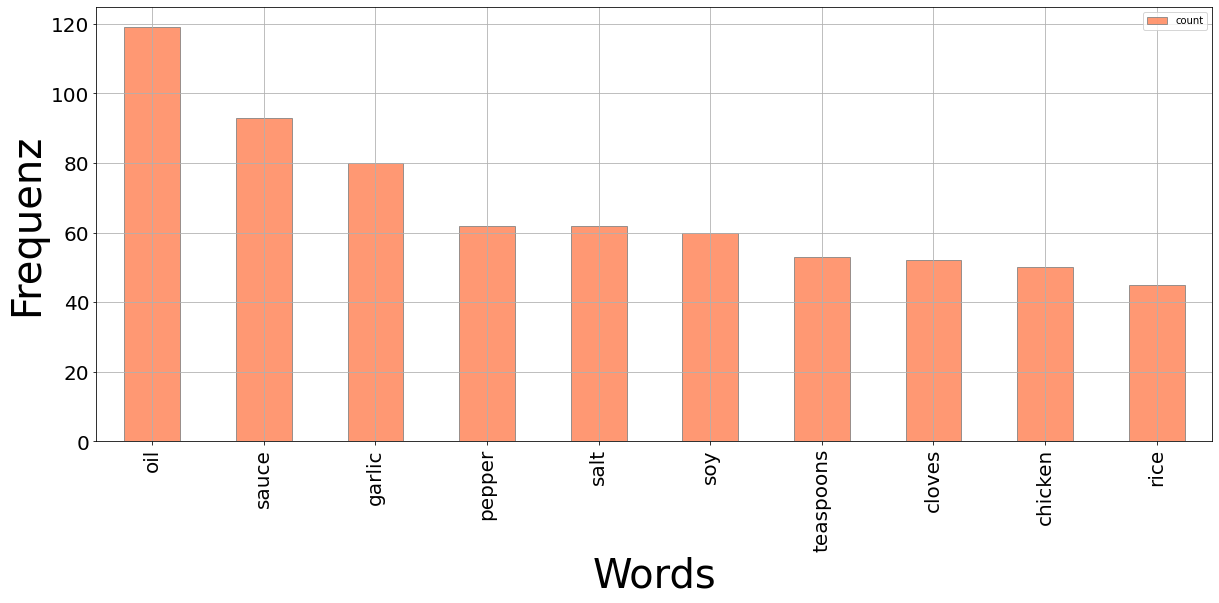

In [24]:
plt.figure()
df1.plot.bar(x='word',y='count', color=['coral'], alpha=0.8,  fontsize=20, figsize=(20, 8),edgecolor = "grey", grid= True)
plt.xlabel('Words', fontsize=40)
plt.ylabel('Frequenz', fontsize=40)
plt.show()

## Top10 most frequent ingredient bigrams

In [25]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['cleanText'], 10)

df2 = pd.DataFrame(common_words, columns = ['words' , 'count'])

df2.head(10)

,words,count
0,olive oil,150
1,soy sauce,145
2,cloves garlic,136
3,black pepper,126
4,fish sauce,77
5,garlic cloves,77
6,sesame oil,75
7,salt black,67
8,salt pepper,65
9,green onions,62


<Figure size 432x288 with 0 Axes>

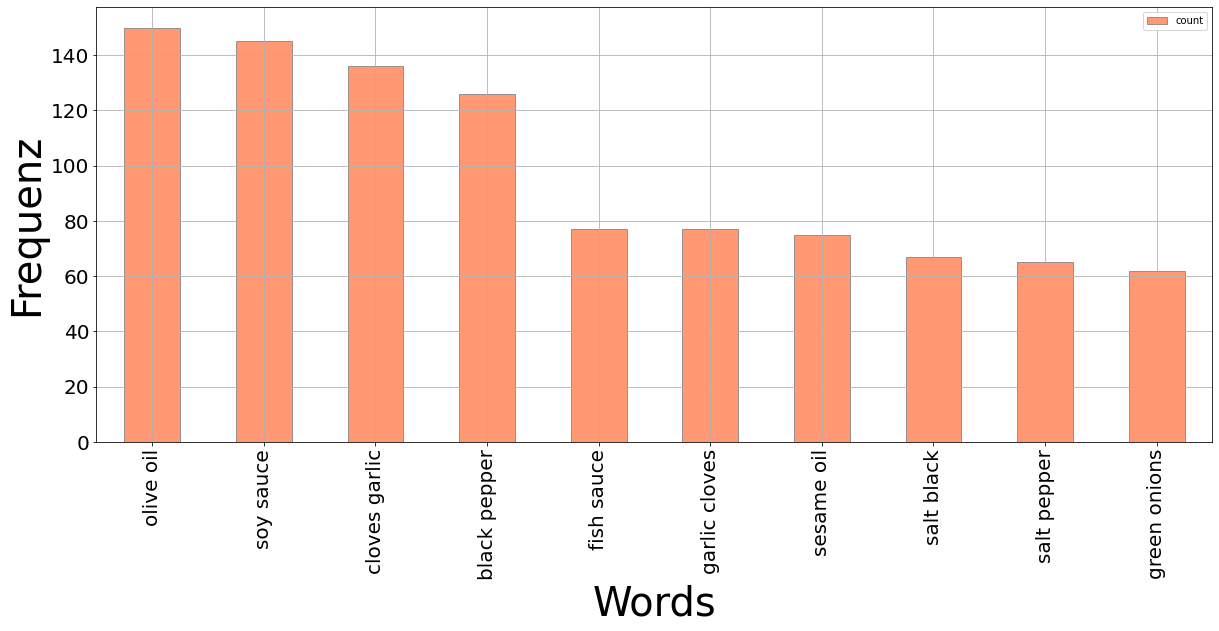

In [26]:
plt.figure()
df2.plot.bar(x='words',y='count', color=['coral'], alpha=0.8,  fontsize=20, figsize=(20, 8),edgecolor = "grey", grid= True)
plt.xlabel('Words', fontsize=40)
plt.ylabel('Frequenz', fontsize=40)
plt.show()

In [27]:
print(new_df['parsed'].iloc[0])



cloves garlic ginger fine sesame oil rice vinegar soy sauce chicken broth vegetable broth water sriracha sugar corn starch


In [70]:
import itertools

a_list= new_df['cleanTextList']
pairs = []

for i in a_list:
    for pair in itertools.combinations(i,2):
        pairs.append(pair)

print(pairs[0:10])
print(Counter(elem[0:2] for elem in pairs).most_common(10))
d = Counter(elem[0:2] for elem in pairs)
singleCombinations = pd.DataFrame.from_records(d.most_common(10), columns=['Combination','count'])
singleCombinations.head(10)

[('cloves', 'garlic'), ('cloves', 'ginger'), ('cloves', 'fine'), ('cloves', 'sesame'), ('cloves', 'oil'), ('cloves', 'rice'), ('cloves', 'vinegar'), ('cloves', 'soy'), ('cloves', 'sauce'), ('cloves', 'chicken')]
[(('soy', 'sauce'), 82), (('garlic', 'sauce'), 64), (('oil', 'oil'), 63), (('oil', 'sauce'), 59), (('sauce', 'oil'), 58), (('garlic', 'oil'), 55), (('oil', 'garlic'), 55), (('oil', 'salt'), 54), (('chicken', 'sauce'), 52), (('teaspoons', 'oil'), 51)]


,Combination,count
0,"(soy, sauce)",82
1,"(garlic, sauce)",64
2,"(oil, oil)",63
3,"(oil, sauce)",59
4,"(sauce, oil)",58
5,"(garlic, oil)",55
6,"(oil, garlic)",55
7,"(oil, salt)",54
8,"(chicken, sauce)",52
9,"(teaspoons, oil)",51


In [ ]:
plt.figure()
df2.plot.bar(x='words',y='count', color=['coral'], alpha=0.8,  fontsize=20, figsize=(20, 8),edgecolor = "grey", grid= True)
plt.xlabel('Combinations', fontsize=40)
plt.ylabel('Frequenz', fontsize=40)
plt.show()

In [64]:
pair_list= new_df['bigrams']
pairs = []

for i in pair_list:
    for pair in itertools.combinations(i,2):
        pairs.append(pair)

print(pairs[0:10])

Counter(elem[0:2] for elem in pairs).most_common(10)

[('cloves garlic', 'garlic ginger'), ('cloves garlic', 'ginger fine'), ('cloves garlic', 'fine sesame'), ('cloves garlic', 'sesame oil'), ('cloves garlic', 'oil rice'), ('cloves garlic', 'rice vinegar'), ('cloves garlic', 'vinegar soy'), ('cloves garlic', 'soy sauce'), ('cloves garlic', 'sauce chicken'), ('cloves garlic', 'chicken broth')]


[(('cloves garlic', 'soy sauce'), 22),
 (('soy sauce', 'sesame oil'), 14),
 (('garlic ginger', 'soy sauce'), 11),
 (('soy sauce', 'sauce teaspoons'), 11),
 (('soy sauce', 'sesame seeds'), 11),
 (('salt black', 'black pepper'), 11),
 (('skinless chicken', 'soy sauce'), 11),
 (('sesame oil', 'soy sauce'), 10),
 (('dark soy', 'soy sauce'), 10),
 (('soy sauce', 'bean sprouts'), 10)]